In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


import gc
import sys

import os
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)

#from teproteus import TEProteusAdmin, TEProteusInst
#from tevisainst import TEVisaInst
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

import mylib as ml

####
import time
import math
import ipywidgets as widgets
# from scipy import signal

In [2]:
SCLK = 1000e6  ### sampling clock
DUC_INTERP = 1  ### the DUC mode

In [3]:
# get the DAC mode, range, Serial port # and the data type of the system (8 or 16bit)
# Make sure the Model name is P9484M, that the name of our module
dac_mode, max_dac, sid, data_type = ml.connection_func() 


=========CONNECTING=========
process id 16504
Connected to: Tabor Electronics,P9484M,000000220642,1.118.0
Model: P9484M
===CONNECTION ESTABLISHED===

===SYSTEM'S INFORMATION===
DAC waveform format: 16 bits-per-point
Max DAC wave-point level: 65535
Half DAC wave-point level: 32767.0
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 8,581,545,984 wave-bytes
==========READY============


In [4]:
admin = TepAdmin()  ### decalring a shortcut to send SCPY commands to the machine
inst = admin.open_instrument(slot_id=sid)  ### decalring a shortcut to send SCPY commands to the machine

In [5]:
# channel_numb = 1
# ml.initialization_func(channel_numb, inst, SCLK)  ### fix the inst

for i in range(0,4):
    channel_numb = i + 1
    ml.initialization_func(channel_numb, inst, SCLK)  ### fix the inst


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error

===INITIALIZATION OF CHANNEL 2===  -->  ===DONE===
ERRORS: 0, no error

===INITIALIZATION OF CHANNEL 3===  -->  ===DONE===
ERRORS: 0, no error

===INITIALIZATION OF CHANNEL 4===  -->  ===DONE===
ERRORS: 0, no error


original seglen: 10000.0

!WARNING! The segment of the defined signal (10000.0 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

formated seglen: 9984


<IPython.core.display.Javascript object>


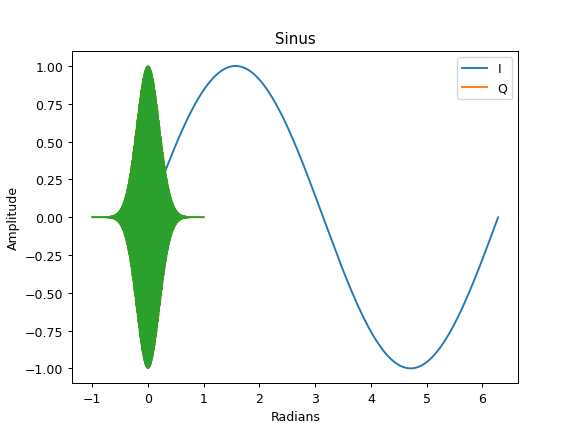

The blank singnal is with time width: 2.048e-06


In [6]:
sin_f, sin_f_seglen = ml.sin_func (100000, 0, SCLK, show_plot = True)  ### creating a sinus shape

blank, blank_seglen = ml.blank_func (SCLK)

sin_f = ml.digital_conv_func(sin_f, max_dac, data_type) ### converting the signal from float format array to a binary format array
blank = ml.digital_conv_func(blank, max_dac, data_type)

period = 1000.0[ns]
sigma = 3400.0[ns]
sigma_num = 3400.0 datapoints 
5 3400.0 17000.0
Gaussian Segement length = 17000 datapoints

Gaussian Segement length (in time) = 17000.0 [ns]]

!WARNING! Sigma is comparable to the period of the oscillation


!WARNING! The segment of the defined signal (17000 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Gaussian frequency = 1.0[Mhz]


<IPython.core.display.Javascript object>


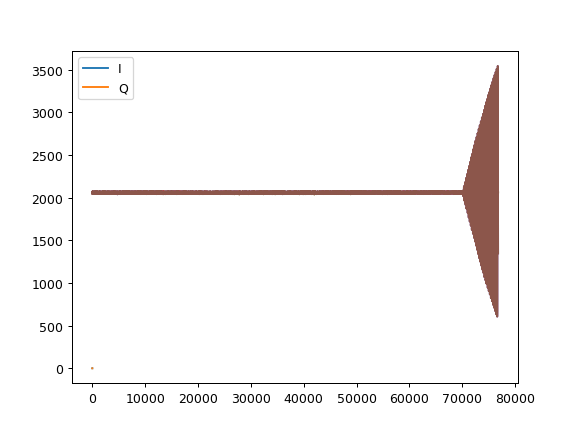

In [14]:
frequency = 10e5 ### frequency of the oscillation
sigma = 340e-08  ### make it bigger then the period of the oscillation 
width_over_sigma = 5    # time width of the gaussian pulse, a.k.a. how many sigmas wide is the pulse, for example - width = [5*sigma], by 

gauss_signal_i, gauss_signal_q, seglen_gauss = ml.prepare_gaussian_pulse (sigma, width_over_sigma, frequency, SCLK, DUC_INTERP, max_dac, show_plot = True)

gauss_signal_i = ml.digital_conv_func(gauss_signal_i, max_dac, data_type)
gauss_signal_q = ml.digital_conv_func(gauss_signal_q, max_dac, data_type)

In [10]:
frequency = 4e6 ### frequency of the oscillation
width = 13e-6

sin_signal_i, sin_signal_q, seglen_sin = ml.prepare_sin_pulse (width, frequency, SCLK, DUC_INTERP, max_dac, show_plot = False)

sin_signal_i = ml.digital_conv_func(sin_signal_i, max_dac, data_type)
sin_signal_q = ml.digital_conv_func(sin_signal_q, max_dac, data_type)

period = 250.0[ns]
Sine segement length = 12999 datapoints

Sine segement length (in time) = 13000.0 [ns]]

!WARNING! The segment of the defined signal (12999 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Signal frequency = 4.0[Mhz]


In [43]:
# channb = 1


In [15]:
wave = gauss_signal_i
wave2 = sin_f
wave3 = blank
wave4 = sin_signal_i

In [19]:
def new_download_func (inst, wave, sid, channel, segment):
    
    # download it to segment 1 of channel 1
    inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))
    inst.send_scpi_cmd(':TRAC:DEF {0},'.format(segment) + str(wave.size))
    inst.send_scpi_cmd(':TRAC:SEL {0}'.format(segment))   # we are saying here basically "create for me a segment of memory with such and such length"

    print('wave size: {0}'.format(wave.size))
    # download the waveform to the selected segment
    inst.write_binary_data(':TRAC:DATA', wave)  # put your wave there

    inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM {0}'.format(segment))
    # inst.send_scpi_cmd(':SOUR:VOLT 0.5')  ### set voltage 
    inst.send_scpi_cmd(':OUTP ON')

    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

    del wave
    
    return None

# download signal to an approprate 'channel' and 'segment of the channel'
ml.download_func (inst, wave, channel = 1, segment = 1)
ml.download_func (inst, wave2, channel = 1, segment = 2)
ml.download_func (inst, wave3, channel = 1, segment = 3)
ml.download_func (inst, wave4, channel = 1, segment = 4)

wave size: 16960
0, no error
wave size: 9984
0, no error
wave size: 2048
0, no error
wave size: 12992
0, no error


In [16]:
 ml.simple_tasker (inst, tasklen = 4, channel = 1)

Current task: 1
Next task will be task: 2
Current task: 2
Next task will be task: 3
Current task: 3
Next task will be task: 4
Current task: 4
Next task will be task: 1
0, no error


In [17]:
##########################################

In [30]:
ml.simple_sequence_task (inst, channel = 1, time_delay = 40, segment_pulse1 = 1, segment_pulse2 = 4, segment_time_delay = 3)

Next task: 1
Next task: 2
0, no error


In [31]:
#########################################

In [32]:
# Setup the digitizer in two-channel mode

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DIG:MODE DUAL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


inst.send_scpi_cmd(':DIG:FREQ 400MHZ')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# Select the internal-trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')

# # Enable capturing data from channel 2
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
# inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# # Select the internal-trigger as start-capturing trigger:
# inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')


0, no error
0, no error
204, data out of range in scpi


0

In [33]:
# Allocate four frames of 4800 samples
numframes, framelen = 1, 8*9600
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

204, data out of range in scpi


In [52]:
# Start the digitizer's capturing machine ###################### START CAPTURE
inst.send_scpi_cmd(':DIG:INIT ON')

# Generate 4 software-triggers
for _ in range(capture_count):
    inst.send_scpi_cmd(':DIG:TRIG:IMM') # this command forces a trigger event for the digitizer when trigger source is set to CPU
    time.sleep(0.1) # more than  enough for capturing single frame
    # Query the status
    resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
    print(resp)

print()

# Stop the digitizer's capturing machine (to be on the safe side) ################# STOP CAPTURE
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

1,1,0,1

0, no error


In [53]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

# # Read the data that was captured by channel 2:
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

# wav2 = np.zeros(wavlen, dtype=np.uint16)
# rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 153600

0, no error


In [54]:
wav1[0]

2060

<IPython.core.display.Javascript object>


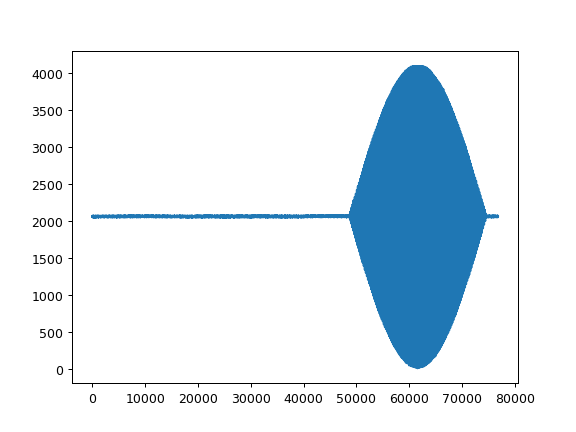

In [55]:
plt.plot(wav1)

In [68]:
#########################################

In [56]:
inst.close_instrument()
admin.close_inst_admin()

# ml.quitter(sid)

0